In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.utils.validation import check_is_fitted

In [2]:
# my data
data = pd.read_csv('/home/giwrikas/Downloads/Morphemic_datasets/all-4 (1).csv')
cols = ["memory_alloc","cpu_alloc","cpu_usage","memory","number_instances"]
data[cols] = data[cols].replace({ 0:np.nan})
data = data.dropna(subset=['number_instances', 'memory_alloc','cpu_alloc'])
data = data.drop(columns=['Unnamed: 0'])

#### Here we are doing a minor modification at the data in order not to have values like 1000000000.0 (and not to observe very big deviation)

In [3]:
data['cpu_alloc'] = data['cpu_alloc'].replace(100000000.0, 1)
data['cpu_alloc'] = data['cpu_alloc'].replace(200000000.0, 2)
data['cpu_alloc'] = data['cpu_alloc'].replace(300000000.0, 3)
data['cpu_alloc'] = data['cpu_alloc'].replace(400000000.0, 4)

In [4]:
data['memory_alloc'] = data['memory_alloc'].replace(248000000.0, 248)

In [5]:
data

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
13,0.000000,0.000000,1.0,6960.363826,0.000000,39.366667,2.0,9.718443e+06,32.0
14,0.000000,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
15,0.000000,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
16,20.333333,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
17,20.333333,8.333333,1.0,6960.363826,33.334054,39.366667,2.0,9.718443e+06,32.0
...,...,...,...,...,...,...,...,...,...
35263,39.428571,16.571429,3.0,6.409822,10.665537,37.100000,3.0,3.025130e+07,248.0
35264,39.428571,16.571429,3.0,6.409822,10.665537,37.100000,3.0,3.025130e+07,248.0
35265,39.428571,16.571429,3.0,13.592183,10.665537,37.100000,3.0,3.025130e+07,248.0
35266,39.428571,16.571429,3.0,13.592183,10.665537,37.100000,3.0,3.025130e+07,248.0


In [6]:
data = data.round(decimals=2)

In [7]:
data.shape

(30507, 9)

In [8]:
# Data Description
data.describe()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
count,30507.000000,30507.000000,30507.000000,30507.000000,30507.000000,29608.000000,30507.000000,2.960900e+04,30507.000000
mean,22.391686,12.816734,1.366047,507.126632,61.012693,38.267292,2.518865,3.148796e+07,98.991051
std,63.763678,37.790858,0.790343,2753.333043,41.012961,9.283692,1.483380,6.424793e+06,84.894916
min,0.000000,0.000000,1.000000,0.000000,0.000000,14.870000,1.000000,2.083499e+06,32.000000
25%,0.000000,0.000000,1.000000,0.000000,7.970000,30.700000,2.000000,2.705818e+07,56.000000
50%,1.000000,0.330000,1.000000,1.520000,66.740000,39.235000,2.000000,3.301786e+07,56.000000
75%,22.110000,10.140000,1.000000,7.310000,100.000000,45.430000,2.000000,3.570483e+07,56.000000
max,636.000000,322.000000,5.000000,55029.400000,218.220000,73.400000,7.000000,5.108668e+07,248.000000


#### Remove rows with response time = 0

In [9]:
data_2 = data.drop(data[data['response_time'] == 0.000000 ].index) 

In [10]:
data_2 = data_2.round(decimals=2)

#### Reset index in dataframe 

In [11]:
data_3 = data_2.reset_index()
data_3 = data_3.drop(columns=['index'])
data_3.head()

,served_request,request_rate,number_instances,response_time,performance,cpu_usage,cpu_alloc,memory,memory_alloc
0,0.00,0.00,1.0,6960.36,0.00,39.37,2.0,9718442.67,32.0
1,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
2,0.00,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
3,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0
4,20.33,8.33,1.0,6960.36,33.33,39.37,2.0,9718442.67,32.0


# Data Imputation technique 1

# Missing Values Imputation 
#### We are using an inheritance from the sklearn.base classes (BaseEstimator, TransformerMixin). 

# Group Data according to configuration and then for each configuration take the mean or the meadian

In [12]:
#Missing Values Imputation 

class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.

    Parameters
    ----------
    group_cols : list
        List of columns used for calculating the aggregated value
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''

    def __init__(self, group_cols, target, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        #assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'

        self.group_cols = group_cols
        self.target = target
        self.metric = metric

    def fit(self, X, y=None):
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'

        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)#
        
        print(impute_map)
        self.impute_map_ = impute_map

        return self

    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')

        X = X.copy()

        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])

        return X.values


conf_columns = ['number_instances', 'cpu_alloc', 'memory_alloc' ]

for col_name in data_2.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        imp = GroupImputer(group_cols=conf_columns,
                           target=col_name,
                           metric='median')

        df_imp = pd.DataFrame(imp.fit_transform(data_2),
                              columns=data_2.columns)



for col_name in data_2.columns:
    if col_name != 'number_instances' and col_name != 'cpu_alloc' and col_name!= 'memory_alloc' :

        print(f'data contains {sum(pd.isnull(data_2[col_name]))} missing values.')
        print(f'df_imp contains {sum(pd.isnull(df_imp[col_name]))} missing values.')


    number_instances  cpu_alloc  memory_alloc  served_request
0                1.0        1.0         248.0           22.33
1                1.0        2.0          32.0           10.67
2                1.0        2.0          48.0          636.00
3                1.0        2.0          56.0            1.00
4                1.0        2.0         248.0           44.67
5                1.0        3.0          32.0           14.33
6                1.0        3.0         248.0           72.50
7                1.0        4.0         248.0           90.67
8                1.0        6.0          32.0           58.33
9                2.0        1.0         248.0           25.20
10               2.0        2.0         248.0           46.80
11               2.0        3.0         248.0           78.80
12               2.0        6.0          32.0          141.00
13               2.0        7.0          32.0            0.60
14               3.0        1.0         248.0           24.29
15      

In [13]:
df_imp.isna().sum()

served_request      0
request_rate        0
number_instances    0
response_time       0
performance         0
cpu_usage           0
cpu_alloc           0
memory              0
memory_alloc        0
dtype: int64

In [14]:
df_imp_1 = df_imp.groupby(['number_instances', 'cpu_alloc', 'memory_alloc']).size().reset_index()

lista = []
for row in df_imp_1.iterrows():
    lista.append(df_imp_1[['number_instances', 'cpu_alloc', 'memory_alloc']])


In [15]:
df_imp_1 = df_imp_1.drop(columns=[0])
dictionairy = df_imp_1.to_dict('index')

In [16]:
def label_race(row):
    
    if row['number_instances'] == 1.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0 :
        return 0
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 32.0:
        return 1
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 48.0:
        return 2
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 56.0:
        return 3
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 4
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 32.0:
        return 5
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 248.0:
        return 6
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 4.0 and row['memory_alloc'] == 248.0:
        return 7
    elif row['number_instances'] == 1.0 and row['cpu_alloc'] == 6.0 and row['memory_alloc'] == 32.0:
        return 8
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 9
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 10
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 248.0:
        return 11
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 6.0 and row['memory_alloc'] == 32.0:
        return 12
    elif row['number_instances'] == 2.0 and row['cpu_alloc'] == 7.0 and row['memory_alloc'] == 32.0:
        return 13
    elif row['number_instances'] == 3.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 14
    elif row['number_instances'] == 3.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 15
    elif row['number_instances'] == 3.0 and row['cpu_alloc'] == 3.0 and row['memory_alloc'] == 248.0:
        return 16
    elif row['number_instances'] == 4.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 17
    elif row['number_instances'] == 4.0 and row['cpu_alloc'] == 2.0 and row['memory_alloc'] == 248.0:
        return 18
    elif row['number_instances'] == 5.0 and row['cpu_alloc'] == 1.0 and row['memory_alloc'] == 248.0:
        return 19
  
df_imp_2 = df_imp.copy()
df_imp_2['configuration'] = df_imp_2.apply (lambda row: label_race(row), axis=1)



In [17]:
df_imp_2['configuration'].unique()

array([ 1,  2,  3,  0,  9, 14, 17, 19,  4, 10, 15, 18,  5,  8, 12, 13,  6,
        7, 11, 16])

In [18]:
df_imp_2['configuration'].isna().sum()

0

In [19]:
df_imp_2.shape

(19925, 10)

# Algorithms Experimentation

## Decision Tree Regressor 

#### 1) Tι συμβαινει αν απλα πεταξω ολες τις γραμμες που εχουν nan values

##### Σε ολα αυτα τα κελια μπορει αντι του Decision Tree Regressor να μπει οποιος αλγοριθμος θελει καποιος να τεσταρει

In [23]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_2.drop(columns=['performance', 'served_request',
                                                                         'response_time', 'memory' , 'cpu_usage'
                             ]),
                                                    df_imp_2['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))


<function cross_val_score at 0x7f4fe4c9cd40>
R2_test:  0.9345271582042805
R2_train:  0.9320632844398
127.46091049842408
11.289858745725036
6.478708520435309


## Something wrong with dataset and train/test split
I suspect that most of the test data (maybe all) are not already unseen. In essence you were testing on seen data. For this reason train with test metrics above give the same number.
Following some random sample which validate my concerns.


In [80]:
X_train[X_train['request_rate']==17.00]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
18415,17.0,1.0,1.0,248.0,0
10778,17.0,2.0,1.0,248.0,9
18427,17.0,1.0,1.0,248.0,0
10783,17.0,2.0,1.0,248.0,9
18424,17.0,1.0,1.0,248.0,0
10781,17.0,2.0,1.0,248.0,9
10770,17.0,2.0,1.0,248.0,9
10769,17.0,2.0,1.0,248.0,9


In [82]:
y_train[18415]

0.44

In [83]:
X_test[X_test['request_rate']==17.00]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
18417,17.0,1.0,1.0,248.0,0
10772,17.0,2.0,1.0,248.0,9
18426,17.0,1.0,1.0,248.0,0


In [84]:
y_test[18417]

0.44

In [85]:
X_train[X_train['request_rate']==49.67]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
17956,49.67,1.0,4.0,248.0,7
17943,49.67,1.0,4.0,248.0,7
17953,49.67,1.0,4.0,248.0,7
17957,49.67,1.0,4.0,248.0,7


In [87]:
y_train[17956]

35.56

In [38]:
X_test[X_test['request_rate']==49.67]

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
17944,49.67,1.0,4.0,248.0,7
18872,49.67,1.0,4.0,248.0,7
17943,49.67,1.0,4.0,248.0,7
17946,49.67,1.0,4.0,248.0,7
18866,49.67,1.0,4.0,248.0,7
17954,49.67,1.0,4.0,248.0,7


In [40]:
y_test[17944]

35.56

## Drop duplicates on dataset

In [22]:
df_imp_2 = df_imp_2.drop_duplicates()

In [25]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_2.drop(columns=['performance', 'served_request',
                                                                         'response_time', 'memory' , 'cpu_usage'
                             ]),
                                                    df_imp_2['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val = cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))


[0.83952746 0.88424507 0.88983686 0.88043853 0.86930341 0.89845793
 0.91525811 0.87277668 0.89103855 0.83410071]
R2_test:  0.8824155102966318
R2_train:  0.8985780285844468
234.96353102787648
15.328520183888479
8.405763357270105


In [24]:
df_imp_2.drop(columns=['performance', 'served_request',
    'response_time', 'memory' , 'cpu_usage'
                             ])

,request_rate,number_instances,cpu_alloc,memory_alloc,configuration
0,0.00,1.0,2.0,32.0,1
1,8.33,1.0,2.0,32.0,1
3,8.33,1.0,2.0,32.0,1
12,8.33,1.0,2.0,32.0,1
15,8.33,1.0,2.0,32.0,1
...,...,...,...,...,...
19911,27.43,3.0,3.0,248.0,16
19913,16.57,3.0,3.0,248.0,16
19916,16.57,3.0,3.0,248.0,16
19922,16.57,3.0,3.0,248.0,16


## Drop without 'performance', 'served_request', 'response_time', 'memory' , 'cpu_usage'


In [25]:
df_imp_3 = df_imp_2.drop(columns=['served_request', 'response_time', 'memory' , 'cpu_usage'])
df_imp_3

,request_rate,number_instances,performance,cpu_alloc,memory_alloc,configuration
0,0.00,1.0,0.00,2.0,32.0,1
1,8.33,1.0,33.33,2.0,32.0,1
2,8.33,1.0,33.33,2.0,32.0,1
3,8.33,1.0,33.33,2.0,32.0,1
4,8.33,1.0,33.33,2.0,32.0,1
...,...,...,...,...,...,...
19920,16.57,3.0,10.67,3.0,248.0,16
19921,16.57,3.0,10.67,3.0,248.0,16
19922,16.57,3.0,10.67,3.0,248.0,16
19923,16.57,3.0,10.67,3.0,248.0,16


In [26]:
df_imp_3 = df_imp_3.drop_duplicates()
df_imp_3

,request_rate,number_instances,performance,cpu_alloc,memory_alloc,configuration
0,0.00,1.0,0.00,2.0,32.0,1
1,8.33,1.0,33.33,2.0,32.0,1
19,8.67,1.0,33.33,2.0,32.0,1
20,8.67,1.0,0.00,2.0,32.0,1
39,17.67,1.0,0.00,2.0,32.0,1
...,...,...,...,...,...,...
19882,62.43,3.0,16.59,3.0,248.0,16
19894,62.43,3.0,18.46,3.0,248.0,16
19896,27.43,3.0,18.46,3.0,248.0,16
19910,27.43,3.0,10.67,3.0,248.0,16


In [265]:
## Decision Tree Regressor for the  Model which uses the configuration variables in order to predict the performance (variable)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_3.drop(columns=['performance']),
                                                    df_imp_3['performance'],random_state=0)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
cross_val = cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))


[0.45655246 0.70537614 0.87557128 0.87112809 0.49078862 0.71633137
 0.58158743 0.82700403 0.90267184 0.74093349]
R2_test:  0.6922191634287532
R2_train:  0.9385552884117815
538.5562497416455
23.206814726317905
10.944953173322576


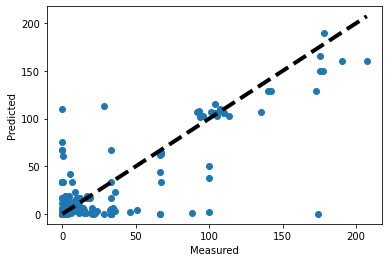

In [42]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

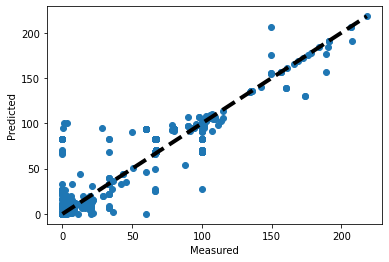

In [53]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(regressor, X_train, y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Use a stacking regressor. I have chosen 3 different algorithms but it can be any algorithm (that it can be used for regression). Unfortunatelly this technique does not improve the results. 

In [283]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV, LassoLarsCV, MultiTaskLassoCV
from sklearn.linear_model import RidgeCV, ElasticNetCV, LarsCV
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import ExtraTreesRegressor

"""lasso_pipeline = make_pipeline(processor_lin,
                               LassoCV())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=42))

gradient_pipeline = make_pipeline(
    processor_nlin,
    HistGradientBoostingRegressor(random_state=0))"""

estimators = [#('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', LarsCV()),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0)),
              ('Elastic Net', ElasticNetCV()),
              ('Extra Trees', ExtraTreesRegressor())
             ]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

stacking_regressor.fit(X_train, y_train)
cross_val = cross_val_score(stacking_regressor, X_train, y_train, cv=10)
print(cross_val)
pred = stacking_regressor.predict(X_test)
pred_train = stacking_regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))

[0.58610053 0.91354041 0.92809087 0.88992676 0.90298853 0.82503617
 0.69726002 0.87763079 0.93736419 0.83628155]
R2_test:  0.8175240166316791
R2_train:  0.8614758629231275
319.2972712841819
17.86889115989523
9.646206734863833


### Support Vector Regression

In [31]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
"""from sklearn.preprocessing import StandardScaler
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X, y)
"""


data_4 = data_3.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_imp_3.drop(columns=['performance']),
                                                    df_imp_3['performance'],random_state=0)
regressor = SVR(kernel = 'poly')
regressor.fit(X_train, y_train)
cross_val = cross_val_score(regressor, X_train, y_train, cv=10)
print(cross_val)
pred = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
# R2_test
print('R2_test: ', r2_score(y_test, pred))
# R2_train
print('R2_train: ', r2_score(y_train, pred_train))
# MSE
print(mean_squared_error(y_test, pred, squared=True))
# RMSE
print(mean_squared_error(y_test, pred, squared=False))
# MAE
print(mean_absolute_error(y_test, pred))

[0.52304187 0.84490812 0.76857999 0.76465386 0.80697308 0.6290279
 0.6565925  0.84734881 0.82239483 0.71821687]
R2_test:  0.7411908348561385
R2_train:  0.7524190941462215
452.86540556393294
21.2806345197678
10.82982518755708


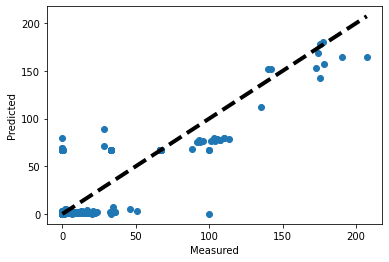

In [32]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(regressor, X_train, y_train, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

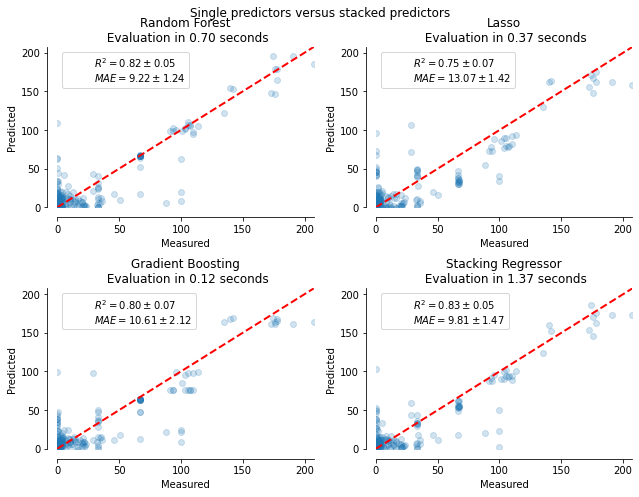

In [112]:
X = X_test
y = y_test
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

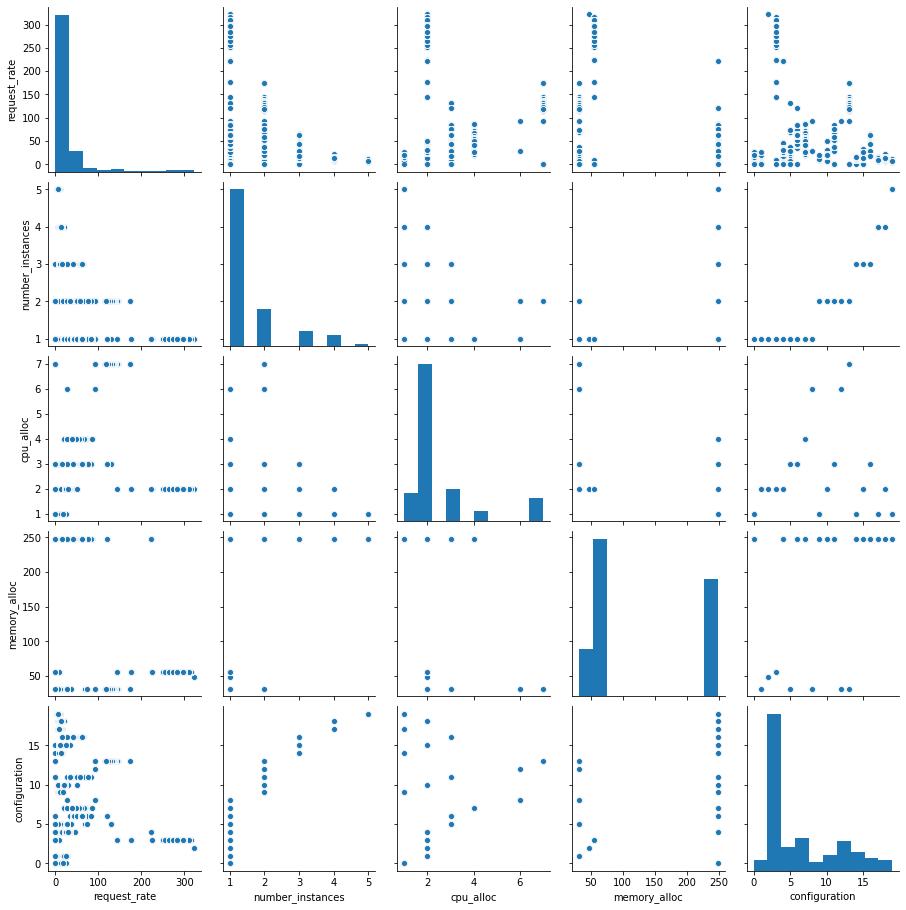

In [42]:
import seaborn as sns
sns.pairplot(data = df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']), vars=df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']).columns)
plt.show()

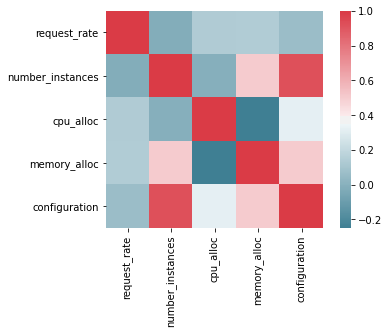

In [43]:
import seaborn as sns
corr = df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

#### The same but with importance writen within in each cell 

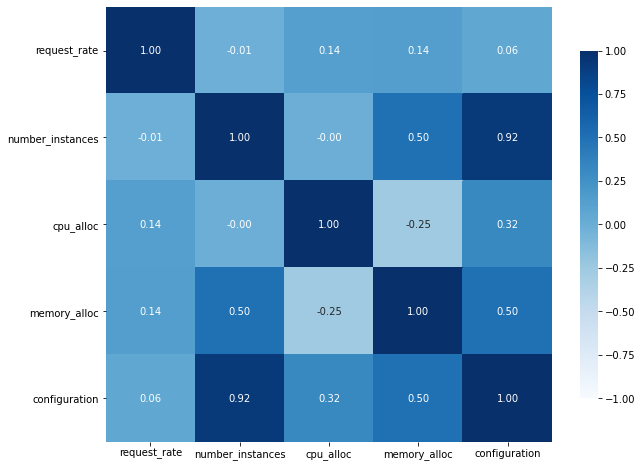

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = df_imp_2.drop(columns=['performance', 'served_request','response_time', 'memory' , 'cpu_usage']).corr()
# plot heatmap
sns.heatmap(corr,  annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

### Model Building & Evaluation

#### FInal look at the data

In [42]:
'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

'''Import basic modules.'''
import pandas as pd
import numpy as np
from scipy import stats

'''Customize visualization
Seaborn and matplotlib visualization.'''
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [48]:
'''Function to plot bar chart'''
def bar_plot(x, y, title, yaxis, c_scale):
    trace = go.Bar(
    x = x,
    y = y,
    marker = dict(color = y, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)    
    
'''Function to plot histogram'''
def plot_histogram(x, title, yaxis, color):
    trace = go.Histogram(x = x,
                        marker = dict(color = color))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

In [43]:
"""Let's have a final look at our data"""
bold('**Data Dimension for Model Building:**')
print('Input matrix dimension:', X_train.shape)
print('Output vector dimension:',y_train.shape)
print('Test data dimension:', X_test.shape)

**Data Dimension for Model Building:**

Input matrix dimension: (803, 5)
Output vector dimension: (803,)
Test data dimension: (268, 5)


In [200]:
'''Set a seed for reproducibility'''
seed = 43

'''Initialize all the regression models object we are interested in.'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


'''We are interested in the following 14 regression models.
All initialized with default parameters except random_state and n_jobs.'''
linear = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
kr = KernelRidge()
elnt = ElasticNet(random_state = seed)
dt = DecisionTreeRegressor(random_state = seed)
svm = SVR()
knn = KNeighborsRegressor(n_jobs = -1)
rf =  RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
xgb = XGBRegressor(random_state = seed, n_jobs = -1)
lgb = LGBMRegressor(random_state = seed, n_jobs = -1)
hist = HistGradientBoostingRegressor()
lasso_cv = LassoCV()

In [201]:
'''Training accuracy of our regression models. By default score method returns coefficient of determination (r_squared).'''
def train_r2(model):
    model.fit(X_train, y_train)
    return model.score(X_train, y_train)

'''Calculate and plot the training accuracy.'''
models = [linear, lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb, hist, lasso_cv]
training_score = []
for model in models:
    training_score.append(train_r2(model))
    
'''Plot dataframe of training accuracy.'''
train_score = pd.DataFrame(data = training_score, columns = ['Training_R2'])
train_score.index = ['LR', 'LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB', 'Hist', 'LassoCV']
train_score = (train_score*100).round(4)
scatter_plot(train_score.index, train_score['Training_R2'], 'Training Score (R_Squared)', 'Models','% Training Score', 30, 'Rainbow')

In [202]:
'''Testing accuracy of our regression models. By default score method returns coefficient of determination (r_squared).'''
def test_r2(model):
    pred = model.predict(X_test)
    return r2_score(pred, y_test)

'''Calculate and plot the training accuracy.'''
models = [linear, lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb, hist, lasso_cv]
testing_score = []
for model in models:
    testing_score.append(test_r2(model))
    
'''Plot dataframe of training accuracy.'''
test_score = pd.DataFrame(data = testing_score, columns = ['Testing_R2'])
test_score.index = ['LR', 'LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB', 'Hist', 'LassoCV']
test_score = (test_score*100).round(4)
scatter_plot(test_score.index, test_score['Testing_R2'], 'Testing Score (R_Squared)', 'Models','% Testing Score', 30, 'Rainbow')

In [195]:
'''Evaluate models on the holdout set(say on 30%).'''
def train_test_split_score(model):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    #X_train, X_test, Y_train, Y_test = train_test_split(df_train_final, y_train, test_size = 0.3, random_state = seed)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mse = mean_squared_error(prediction, y_test)
    rmse = np.sqrt(mse)
    return rmse

'''Calculate train_test_split score of differnt models and plot them.'''
models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb, hist]
train_test_split_rmse = []
for model in models:
    train_test_split_rmse.append(train_test_split_score(model))

'''Plot data frame of train test rmse'''
train_test_score = pd.DataFrame(data = train_test_split_rmse, columns = ['Train_Test_RMSE'])
train_test_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB', 'Hist']
train_test_score = train_test_score.round(5)
x = train_test_score.index
y = train_test_score['Train_Test_RMSE']
title = "Models' Test Score (RMSE) on Holdout(30%) Set"
scatter_plot(x, y, title, 'Models','RMSE', 30, 'RdBu')

In [196]:
'''Function to compute cross validation scores.'''
def cross_validate(model):
    from sklearn.model_selection import cross_val_score
    neg_x_val_score = cross_val_score(model, X_train, y_train, cv = 10, n_jobs = -1, scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    return x_val_score.mean()

def cross_validate_2(model):
    from sklearn.model_selection import cross_val_score
    r2 = cross_val_score(model, X_train, y_train, cv = 10, n_jobs = -1, scoring = 'r2')
    x_val_score = np.round(r2, 5)
    return x_val_score.mean()

'''Calculate cross validation score of differnt models and plot them.'''
models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb, hist]
cross_val_scores = []
for model in models:
    cross_val_scores.append(cross_validate(model))

'''Plot data frame of cross validation scores.'''
x_val_score = pd.DataFrame(data = cross_val_scores, columns = ['Cross Validation Scores (RMSE)'])
x_val_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB', 'Hist']
x_val_score = x_val_score.round(5)
x = x_val_score.index
y = x_val_score['Cross Validation Scores (RMSE)']
title = "Models' 10-fold Cross Validation Scores (RMSE)"
scatter_plot(x, y, title, 'Models','RMSE', 30, 'Viridis')

In [140]:
def grid_search_cv(model, params):
    global best_params, best_score
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 10, verbose = 1,
                            scoring = 'r2', n_jobs = -1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_ 
    #best_score = np.sqrt(-1*(np.round(grid_search.best_score_, 5)))
    best_score = grid_search.best_score_
    return best_params, best_score

#### Optimize Lasso

In [141]:
''''Define hyperparameters of lasso.'''
alpha = [0.0001, 0.0002, 0.00025, 0.0003, 0.00031, 0.00032, 0.00033, 0.00034, 0.00035, 0.00036, 0.00037, 0.00038, 
         0.0004, 0.00045, 0.0005, 0.00055, 0.0006, 0.0008,  0.001, 0.002, 0.005, 0.007, 0.008, 0.01]

lasso_params = {'alpha': alpha,
               'random_state':[seed]}

grid_search_cv(lasso, lasso_params)
lasso_best_params, lasso_best_score = best_params, best_score
print('Lasso best params:{} & best_score:{:0.5f}' .format(lasso_best_params, lasso_best_score))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


Lasso best params:{'alpha': 0.01, 'random_state': 43} & best_score:0.75657


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.3s finished


In [142]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

#### Optimize Ridge

In [143]:
''''Define hyperparameters of ridge.'''
ridge_params = {'alpha':[ 9, 9.2, 9.4, 9.5, 9.52, 9.54, 9.56, 9.58, 9.6, 9.62, 9.64, 9.66, 9.68, 9.7,  9.8],
               'random_state':[seed]}

grid_search_cv(ridge, ridge_params)
ridge_best_params, ridge_best_score = best_params, best_score
print('Ridge best params:{} & best_score:{:0.5f}' .format(ridge_best_params, ridge_best_score))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Ridge best params:{'alpha': 9.8, 'random_state': 43} & best_score:0.75661


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


#### Optimize Kernel Ridge

In [144]:
'''Define hyperparameters of kernel ridge'''
kernel_params = {'alpha':[0.27, 0.28, 0.29, 0.3],
                'kernel':['polynomial', 'linear'], 
                'degree':[2, 3],
                'coef0':[3.5, 4, 4.2]}
grid_search_cv(kr, kernel_params)
kernel_best_params, kernel_best_score = best_params, best_score
print('Kernel Ridge best params:{} & best_score:{:0.5f}' .format(kernel_best_params, kernel_best_score))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s


Kernel Ridge best params:{'alpha': 0.3, 'coef0': 3.5, 'degree': 2, 'kernel': 'polynomial'} & best_score:0.82790


[Parallel(n_jobs=-1)]: Done 457 out of 480 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.3s finished


#### Optimize Elastic Net

In [145]:
'''Define hyperparameters of Elastic net.'''
elastic_params = {'alpha': [ 0.0003, 0.00035, 0.00045, 0.0005], 
                 'l1_ratio': [0.80, 0.85, 0.9, 0.95],
                 'random_state':[seed]}
grid_search_cv(elnt, elastic_params)
elastic_best_params, elastic_best_score = best_params, best_score
print('Elastic Net best params:{} & best_score:{:0.5f}' .format(elastic_best_params, elastic_best_score))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


Elastic Net best params:{'alpha': 0.0005, 'l1_ratio': 0.8, 'random_state': 43} & best_score:0.75656


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.2s finished


#### Optimize Support Vector Machine

In [146]:
'''Define hyperparameters of support vector machine'''
svm_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # precomputed is omitted from kernel to avoid error.
    'C': [4, 5], 
    'gamma':[0.0001, 0.001]}

grid_search_cv(svm, svm_params)
svm_best_params, svm_best_score = best_params, best_score
print('SVM best params:{} & best_score:{:0.5f}' .format(svm_best_params, svm_best_score))
# Don't bother it takes some time. Training is usually more slower in svm.

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 137 out of 160 | elapsed:   36.5s remaining:    6.1s


SVM best params:{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'} & best_score:0.79495


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   46.0s finished


#### Optimize XGB, GB, and LGB

In [156]:
'''Hyperparameters of xgb'''
xgb_opt = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.04, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2500,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, silent = 1,
                             nthread = -1, random_state = 7)

'''Hyperparameters of gb'''
gb_opt = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = seed)
'''Hyperparameters of lgb'''
lgb_opt = LGBMRegressor(objective = 'regression', num_leaves = 5,
                              learning_rate=0.05, n_estimators = 660,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed = 9, bagging_seed = 9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

'''We can assume these 3 model best score is equal to cross validation scores.
Thought it might not be precise, but I will take it'''
xgb_best_score = cross_validate_2(xgb_opt)
gb_best_score = cross_validate_2(gb_opt)
lgb_best_score = cross_validate_2(lgb_opt)

#### K neighboors Regressor

In [184]:
knn_params = {
    'n_neighbors': [3,4,5,6,7], 
    'algorithm': ['auto', 'bal_tree', 'kd_tree', 'brute'], 
    }

grid_search_cv(knn, knn_params)
knn_best_params, knn_best_score = best_params, best_score
print('KNN best params:{} & best_score:{:0.5f}' .format(knn_best_params, knn_best_score))


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s


KNN best params:{'algorithm': 'brute', 'n_neighbors': 7} & best_score:0.82970


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished


#### Hist Gradient Boosting Regressor

In [199]:
HistGradientBoostingRegressor

Hist_params = {
    'loss' : ['least_squares','least_absolute_deviation','poisson'],
    'max_leaf_nodes' : [30, 31, 32, 33]
}

grid_search_cv(hist, Hist_params)
hist_best_params, hist_best_score = best_params, best_score
print('KNN best params:{} & best_score:{:0.5f}' .format(hist_best_params, hist_best_score))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s


KNN best params:{'loss': 'least_squares', 'max_leaf_nodes': 30} & best_score:0.83769


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.1s finished


In [182]:
 optimized_scores

,Optimized Scores
Lasso,0.75657
Ridge,0.75661
Kernel_ridge,0.82790
E_net,0.75656
SVM,0.79495
XGB,0.77345
GB,0.83278
LGB,0.82512


In [204]:
"""Let's plot the models' rmse after optimization."""
optimized_scores = pd.DataFrame({'Optimized Scores':np.round([lasso_best_score, ridge_best_score, kernel_best_score, 
                  elastic_best_score, svm_best_score, xgb_best_score, gb_best_score, lgb_best_score, 
                        knn_best_score, hist_best_score], 5)})
optimized_scores.index = ['Lasso', 'Ridge', 'Kernel_ridge', 'E_net', 'SVM', 'XGB', 'GB', 'LGB', 'KNN', 'Hist']
optimized_scores.sort_values(by = 'Optimized Scores')
scatter_plot(optimized_scores.index, optimized_scores['Optimized Scores'], "Models' Scores after Optimization", 'Models','Optimized Scores', 40, 'Rainbow')

#### Retrain and Predict Using Best Hyperparameters

In [216]:
'''Initialize 8 object models with best hyperparameters'''
lasso_opt = Lasso(**lasso_best_params)
ridge_opt = Ridge(**ridge_best_params)
kernel_ridge_opt = KernelRidge(**kernel_best_params)
elastic_net_opt = ElasticNet(**elastic_best_params)
svm_opt = SVR(**svm_best_params)
xgb_opt = xgb_opt
gb_opt = gb_opt
lgb_opt = lgb_opt
knn_opt = KNeighborsRegressor(**knn_best_params)
hist_opt = HistGradientBoostingRegressor(**best_params)

In [224]:
'''Now train and predict with optimized models'''
def predict_with_optimized_models(model):
    model.fit(X_train, y_train)
    y_pred = np.expm1(model.predict(X_test))
    submission = pd.DataFrame()
    #submission['Id']= 
    submission['SalePrice'] = y_pred
    return submission

'''Make submission with optimized lasso, ridge, kernel_ridge, elastic_net and svm, xgb, gb, and lgb.'''
predict_with_optimized_models(lasso_opt).to_csv('lasso_optimized.csv', index = False)
predict_with_optimized_models(ridge_opt).to_csv('ridge_optimized.csv', index = False)
predict_with_optimized_models(kernel_ridge_opt).to_csv('kernel_ridge_optimized.csv', index = False)
predict_with_optimized_models(elastic_net_opt).to_csv('elastic_net_optimized.csv', index = False)
predict_with_optimized_models(svm_opt).to_csv('svm_opt_optimized.csv', index = False)
predict_with_optimized_models(xgb_opt).to_csv('xgb_optimized.csv', index = False)
predict_with_optimized_models(gb_opt).to_csv('gb_optimized.csv', index = False)
predict_with_optimized_models(lgb_opt).to_csv('lgb_optimized.csv', index = False)
#predict_with_optimized_models(knn_opt).to_csv('knn_optimized.csv', index = False)
predict_with_optimized_models(hist_opt).to_csv('hist_optimized.csv', index = False)

[19:31:54] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/giwrikas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

overflow encountered in expm1



[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [226]:
'''Function to plot scatter plot of feature importance of lasso, ridge and elastic net.'''
def plot_feature_importance(model, title):
    model.fit(X_train, y_train)
    coef = pd.DataFrame({'Feature':X_train.columns,'Importance':np.transpose(model.coef_)})
    coef = coef.set_index('Feature')
    trace = go.Scatter(x = coef.index, y = coef.Importance, mode = 'markers',
            marker = dict(color = np.random.randn(500), size = 20, showscale = True, colorscale = 'Hot'))
    layout = go.Layout(hovermode = 'closest', title = title, yaxis = dict(title = 'Importance'))
    fig = go.Figure(data = [trace], layout = layout)
    iplot(fig)

'''Now plot feature importance of optimized lasso, ridge, and elastic net.'''
plot_feature_importance(lasso_opt, 'Lasso Feature Importance')
plot_feature_importance(ridge_opt, 'Ridge Feature Importance')
plot_feature_importance(elastic_net_opt, 'ElasticNet Feature Importance')


In [162]:
'''Now plot feature importance given by xgb, gb, and lgb.'''
def plot_featute_importance(model, title):
    importance = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_})
    importance = importance.set_index('Features')
    trace = go.Scatter(x = importance.index, y = importance.Importance, mode = 'markers',
                      marker = dict(color = np.random.randn(500), size = 20, showscale = True, colorscale = 'Rainbow'))
    layout = go.Layout(hovermode = 'closest', title = title, yaxis = dict(title = 'Importance'))
    fig = go.Figure(data = [trace], layout = layout)
    iplot(fig)
    
plot_featute_importance(xgb_opt, 'XGB Feature Importance')
plot_featute_importance(gb_opt, 'GB Feature Importance')
plot_featute_importance(lgb_opt, 'LGB Feature Importance')

#### Learning Curves 

In [208]:
'''Create a function to plot learning curves.'''
def plot_learning_curve(model):
    from sklearn.model_selection import learning_curve
    
    # df_train_final is training matrix and y_train is target matrix.
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                            df_imp_3.drop(columns=['performance']), 
                                            df_imp_3['performance'], 
                                            train_sizes = np.linspace(0.01, 1.0, 20), cv = 10, scoring = 'neg_mean_squared_error', 
                                            n_jobs = -1, random_state = seed)
    
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  
    
    # Draw lines
    plt.plot(train_sizes, train_mean, 'o-', color = 'red',  label = 'Training score')
    plt.plot(train_sizes, test_mean, 'o-', color = 'green', label = 'Cross-validation score')
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'r') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'g')
    
    
    # Create plot
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('Accuracy Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()

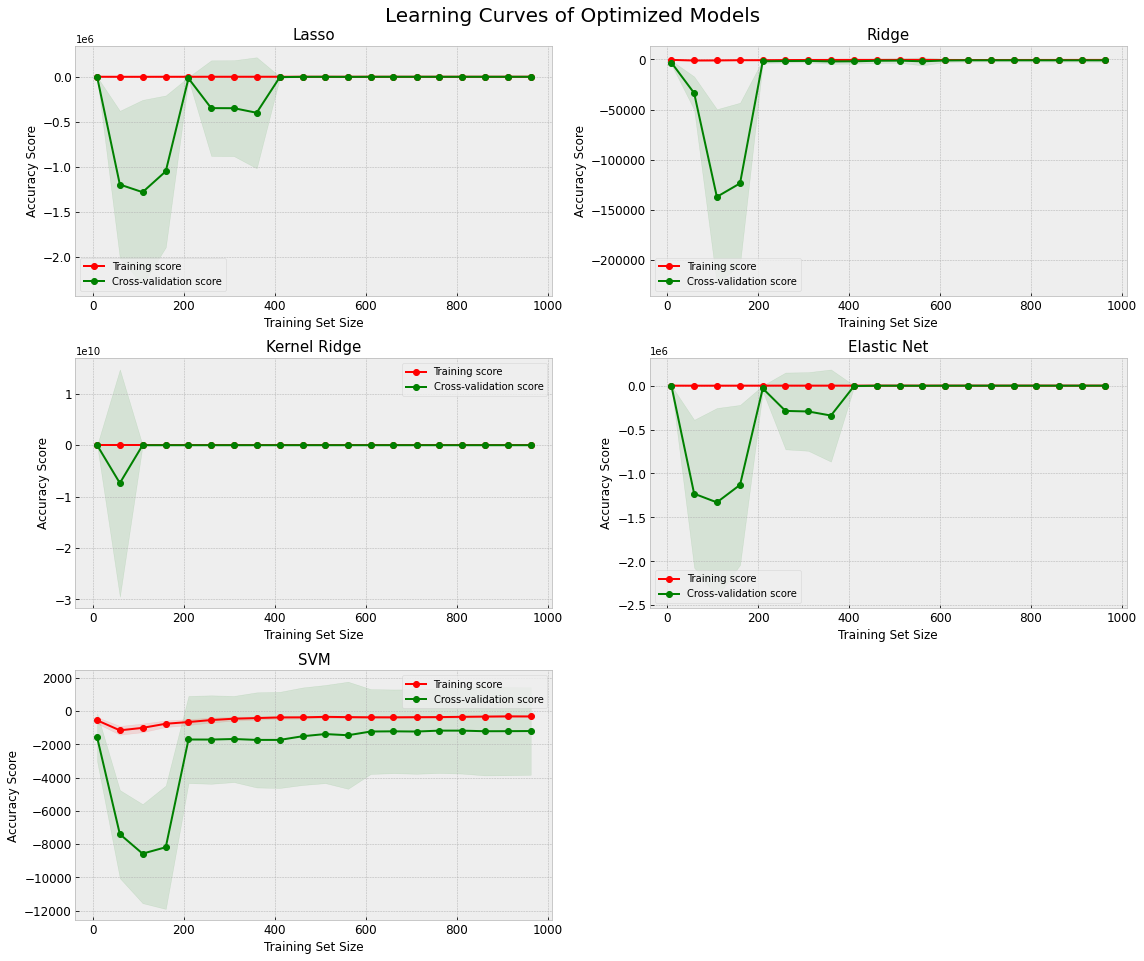

In [211]:
'''Now plot learning curves of the optimized models in subplots.
For computational reason, I am omitting XGB, GB, and LGB.'''
plt.figure(figsize = (16,14))
lc_models = [lasso_opt, ridge_opt, kernel_ridge_opt, elastic_net_opt, svm_opt, knn_opt, hist_opt]
lc_labels = ['Lasso', 'Ridge', 'Kernel Ridge', 'Elastic Net', 'SVM', 'Knn', 'HistGBR']

for ax, models, labels in zip (range(1,6), lc_models, lc_labels):
    plt.subplot(3,2,ax)
    plot_learning_curve(models)
    plt.title(labels, fontsize = 15)
plt.suptitle('Learning Curves of Optimized Models', fontsize = 20)
plt.tight_layout(rect = [0, 0.03, 1, 0.97])

In [165]:
'''Data frame of our optimized base model predictions.'''
base_model_prediction = pd.DataFrame({'LGB':lgb_opt.predict(X_test), 'Lasso':lasso_opt.predict(X_test), 'Ridge':ridge_opt.predict(X_test), 'GB':gb_opt.predict(X_test), 'Kernel Ridge':kernel_ridge_opt.predict(X_test),'Elastic Net':elastic_net_opt.predict(X_test), 'XGB':xgb_opt.predict(X_test), 'SVM':svm_opt.predict(X_test)})
bold('**All the Base Model Predictions:**')
display(base_model_prediction.head())

**All the Base Model Predictions:**

,LGB,Lasso,Ridge,GB,Kernel Ridge,Elastic Net,XGB,SVM
0,0.925822,3.415307,3.391807,1.211700,3.525776,3.427588,2.591941,0.837188
1,1.344432,2.761100,2.856297,0.141157,0.731163,2.721585,0.087443,0.417999
2,9.830794,3.420050,3.343412,6.060909,8.174198,3.454359,12.444642,1.960999
3,107.171887,102.031724,101.961984,106.642474,105.551363,102.043278,107.038109,103.119086
4,0.908223,6.725506,6.773510,9.130444,15.085419,6.695845,6.265236,5.890177


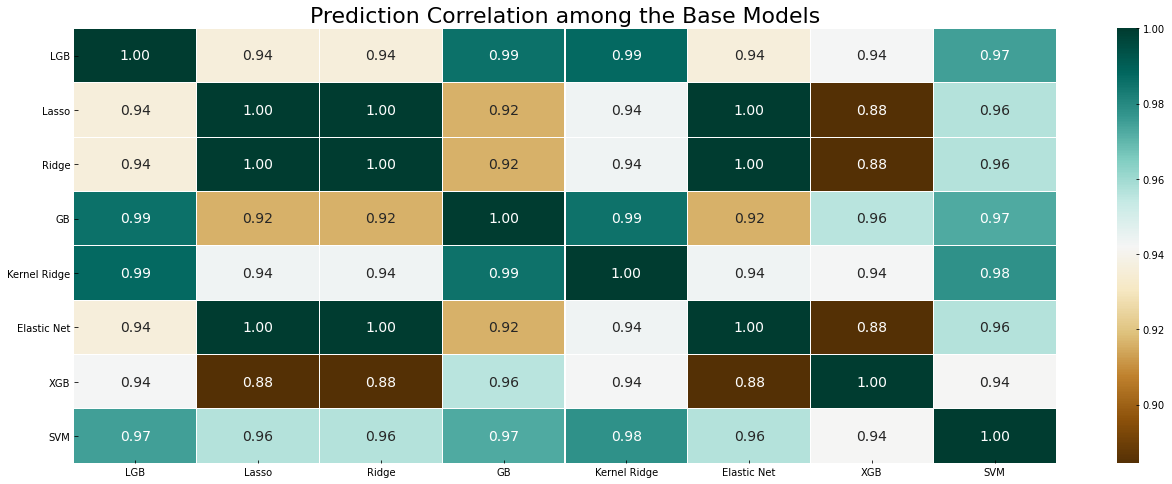

In [166]:
"""Let's visualize the correlations among the predictions of base models."""
fig, ax = plt.subplots(figsize = (22, 8))
sns.heatmap(base_model_prediction.corr(), annot = True, cmap ='BrBG', ax = ax, fmt='.2f', linewidths = 0.05, annot_kws = {'size': 14})
ax.set_title('Prediction Correlation among the Base Models', fontsize = 22)
plt.show()

#### Simple assemble model prediction (neg_mean_squared_error)

In [169]:
"""Now let's build a simple averaging ensemble and predict with it."""
y_kernel_ridge = np.expm1(kernel_ridge_opt.predict(X_test))
y_svm = np.expm1(svm_opt.predict(X_test))
y_lgb = np.expm1(lgb_opt.predict(X_test))
y_gb = np.expm1(gb_opt.predict(X_test))
y_ridge = np.expm1(ridge_opt.predict(X_test))

'''Just average the 5 prediction to form final prediction.'''
avg_ensemble = (y_kernel_ridge + y_lgb + y_svm + y_gb + y_ridge)/5
print(r2_score(y_kernel_ridge, y_test))


-0.006027863446669057


#### Simple assemble model prediction (R2)

In [170]:
"""Now let's build a simple averaging ensemble and predict with it."""
y_kernel_ridge = (kernel_ridge_opt.predict(X_test))
y_svm = svm_opt.predict(X_test)
y_lgb = lgb_opt.predict(X_test)
y_gb = gb_opt.predict(X_test)
y_ridge = ridge_opt.predict(X_test)

'''Just average the 5 prediction to form final prediction.'''
avg_ensemble = (y_kernel_ridge + y_lgb + y_svm + y_gb + y_ridge)/5
print(r2_score(y_kernel_ridge, y_test))

0.773180172511681


#### Stacking Regressor with 

In [249]:
from vecstack import stacking
from sklearn.metrics import mean_squared_error

'''Initialize base models. We will use the same base models as averaging ensemble.'''
base_models = [kernel_ridge_opt, svm_opt, lgb_opt, gb_opt, ridge_opt]

bold('**Performing Stacking...**')
'''Perform stacking.'''
S_train, S_test = stacking(base_models,                # list of base models
                           X_train, y_train, X_test,   # data
                           regression = True,          # We need regression - set to True)
                                                       
                           mode = 'oof_pred_bag',      # mode: oof for train set, predict test 
                                                       # set in each fold and vote
                           needs_proba = False,        # predict class labels (if you need 
                                                       # probabilities - set to True) 
                           save_dir = None,            # do not save result and log (to save 
                                                       # in current dir - set to '.')
                           metric = r2_score,# metric: callable
                           n_folds = 10,               # number of folds
                           stratified = False,         # stratified split for folds
                           shuffle = True,             # shuffle the data
                           random_state =  seed,       # ensure reproducibility
                           verbose = 1)                # print progress
bold('**Stacking Done...**')

**Performing Stacking...**

task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [KernelRidge]
    ----
    MEAN:     [0.82404191] + [0.13866077]
    FULL:     [0.83884599]

model  1:     [SVR]
    ----
    MEAN:     [0.78560918] + [0.14885672]
    FULL:     [0.80672572]

model  2:     [LGBMRegressor]
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319

    ----
    MEAN:     [0.82615654] + [0.14395012]
    FULL:     [0.84279251]

model  4:     [Ridge]
    ----
    MEAN:     [0.74245909] + [0.15311129]
    FULL:     [0.76681453]



**Stacking Done...**

In [250]:
'''Input features for meta learner.'''
bold('**Input Features for Meta Learner:**')
display(S_train[:5])
display(S_train.shape)

**Input Features for Meta Learner:**

array([[62.81702805, 66.47918069, 60.6333038 , 45.11087389, 45.35638155],
       [ 0.85673904,  0.43160297,  1.69047721,  0.10033956,  2.79662508],
       [ 9.05332184,  2.81875865,  7.87192502,  9.80565137,  5.58542018],
       [59.13113415, 47.97035439, 66.92502077, 66.41757104, 48.53984131],
       [63.00656176, 66.89056463, 65.0707165 , 66.11747702, 44.71278789]])

(803, 5)

In [251]:
'''Test (prediction) set for meta learner.'''
bold('**Test Set for Meta Learner:**')
display(S_test[:5].shape)
display(S_test.shape)

**Test Set for Meta Learner:**

(5, 5)

(268, 5)

In [252]:
"""Initialize 1st level model that is our meta learner. We will use kernel ridge."""
super_learner = kernel_ridge_opt 

'''Fit meta learner on the output of base learners.'''
print('Fitting Stacking...')
super_learner.fit(S_train, y_train)
print('Done.')

Fitting Stacking...
Done.


In [253]:
'''Finally predict using super learner.'''
y_pred_super = np.expm1(super_learner.predict(S_test))

print(r2_score(super_learner.predict(S_test), y_test))


0.7698221311692488


In [254]:
"""Initialize 1st level model that is our meta learner. We will use kernel ridge."""
super_learner = kernel_ridge_opt 

'''Fit meta learner on the output of base learners.'''
print('Fitting Stacking...')
super_learner.fit(S_train, y_train)
print('Done.')

print(r2_score(super_learner.predict(S_test), y_test))


Fitting Stacking...
Done.
0.7698221311692488


#### Different models used in Stacking Regressor 

In [269]:
from vecstack import stacking
from sklearn.metrics import mean_squared_error

'''Initialize base models. We will use the same base models as averaging ensemble.'''
base_models = [rf, lasso_cv, hist_opt, lgb_opt]

bold('**Performing Stacking...**')
'''Perform stacking.'''
S_train, S_test = stacking(base_models,                # list of base models
                           X_train, y_train, X_test,   # data
                           regression = True,          # We need regression - set to True)
                                                       
                           mode = 'oof_pred_bag',      # mode: oof for train set, predict test 
                                                       # set in each fold and vote
                           needs_proba = False,        # predict class labels (if you need 
                                                       # probabilities - set to True) 
                           save_dir = None,            # do not save result and log (to save 
                                                       # in current dir - set to '.')
                           metric = r2_score,# metric: callable
                           n_folds = 10,               # number of folds
                           stratified = False,         # stratified split for folds
                           shuffle = True,             # shuffle the data
                           random_state =  seed,       # ensure reproducibility
                           verbose = 1)                # print progress
bold('**Stacking Done...**')

**Performing Stacking...**

task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [RandomForestRegressor]
    ----
    MEAN:     [0.77985396] + [0.10368604]
    FULL:     [0.78131523]

model  1:     [LassoCV]
    ----
    MEAN:     [0.76691634] + [0.07676435]
    FULL:     [0.76755647]

model  2:     [HistGradientBoostingRegressor]
    ----
    MEAN:     [0.84654177] + [0.07187457]
    FULL:     [0.84331215]

model  3:     [LGBMRegressor]
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_

**Stacking Done...**

In [270]:
"""Initialize 1st level model that is our meta learner. We will use kernel ridge."""
super_learner = kernel_ridge_opt 

'''Fit meta learner on the output of base learners.'''
print('Fitting Stacking...')
super_learner.fit(S_train, y_train)
print('Done.')

print(r2_score(super_learner.predict(S_test), y_test))


Fitting Stacking...
Done.
0.8072569998715233
